In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA

sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
df = pd.read_csv("exoplanets_1.csv")


In [4]:
# Useful numeric columns we'll coerce (add more as needed)
num_cols = [
    "pl_orbper","pl_orbsmax","pl_rade","pl_radj","pl_bmasse","pl_bmassj",
    "pl_orbeccen","pl_insol","pl_eqt",
    "st_teff","st_rad","st_mass","st_met",
    "ra","dec","sy_dist","disc_year","sy_snum","sy_pnum"
]
# coerce to numeric (non-numeric -> NaN)
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [5]:
# quick overview
print("Rows:", len(df))
print("Numeric columns available:", [c for c in num_cols if c in df.columns])
print("Missingness (percent) for main numeric columns:")
print(df[num_cols].isna().mean().round(3) * 100)


Rows: 38090
Numeric columns available: ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'ra', 'dec', 'sy_dist', 'disc_year', 'sy_snum', 'sy_pnum']
Missingness (percent) for main numeric columns:
pl_orbper       8.4
pl_orbsmax     43.5
pl_rade        30.7
pl_radj        30.7
pl_bmasse      83.4
pl_bmassj      83.4
pl_orbeccen    51.8
pl_insol       56.1
pl_eqt         56.2
st_teff         7.9
st_rad          7.7
st_mass        15.1
st_met         36.2
ra              0.0
dec             0.0
sy_dist         2.2
disc_year       0.0
sy_snum         0.0
sy_pnum         0.0
dtype: float64


In [6]:
# ----------------------------
# 2) Derived features
# ----------------------------
# log transforms to reduce skew (safe: add small constant)
for c in ["pl_orbper","pl_orbsmax","pl_rade","pl_bmasse","pl_insol","pl_eqt","st_teff","sy_dist"]:
    if c in df.columns:
        df[f"log_{c}"] = np.log10(df[c].clip(lower=1e-9) + 1e-9)  # log10(1e-9 + value)

# Estimate planetary bulk density (g/cm^3) when radius (Earth) and mass (Earth) present
# Earth constants
M_earth_kg = 5.9722e24
R_earth_m = 6371e3
if "pl_bmasse" in df.columns and "pl_rade" in df.columns:
    mass_kg = df["pl_bmasse"] * M_earth_kg
    radius_m = df["pl_rade"] * R_earth_m
    volume_m3 = 4/3 * np.pi * radius_m**3
    df["pl_density_gcm3"] = (mass_kg / volume_m3) * 1000  # kg/m3 -> g/cm3
    df.loc[np.isinf(df["pl_density_gcm3"]), "pl_density_gcm3"] = np.nan

# quick derived-check
print("Derived columns:", [c for c in df.columns if c.startswith("log_")] + (["pl_density_gcm3"] if "pl_density_gcm3" in df.columns else []))

Derived columns: ['log_pl_orbper', 'log_pl_orbsmax', 'log_pl_rade', 'log_pl_bmasse', 'log_pl_insol', 'log_pl_eqt', 'log_st_teff', 'log_sy_dist', 'pl_density_gcm3']


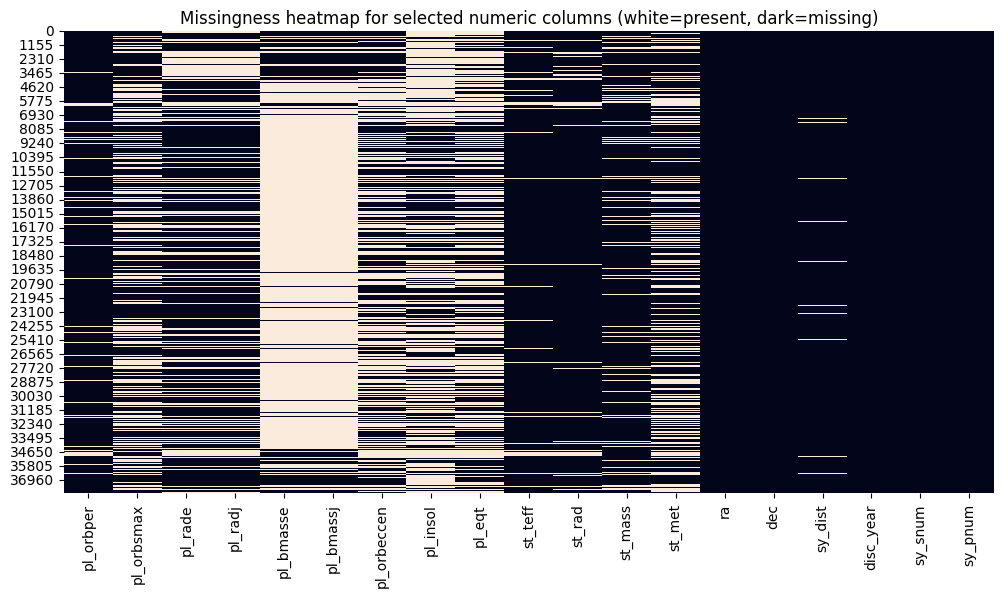

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df[num_cols].isna(), cbar=False)
plt.title("Missingness heatmap for selected numeric columns (white=present, dark=missing)")
plt.show()


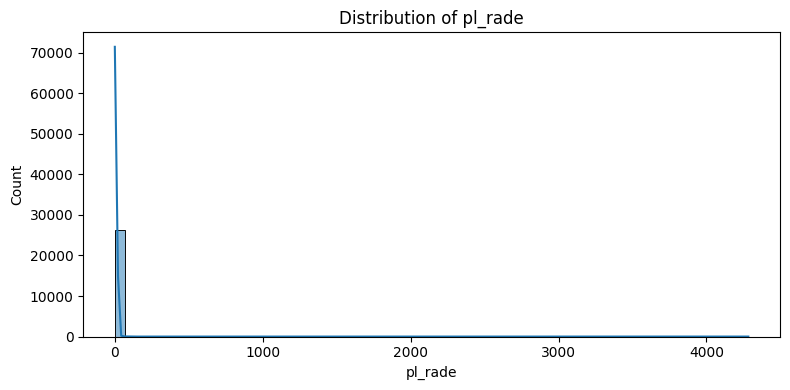

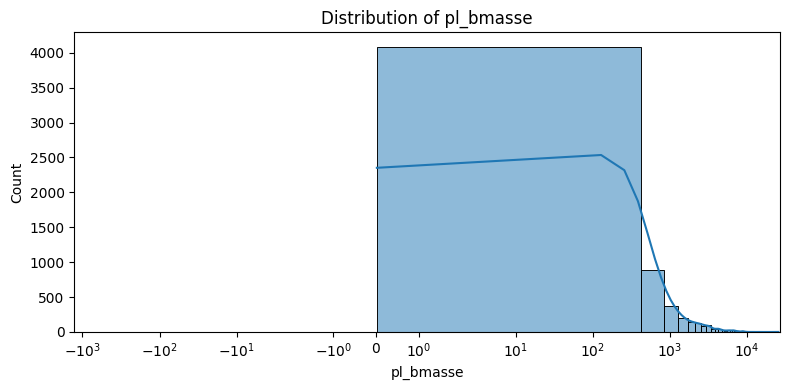

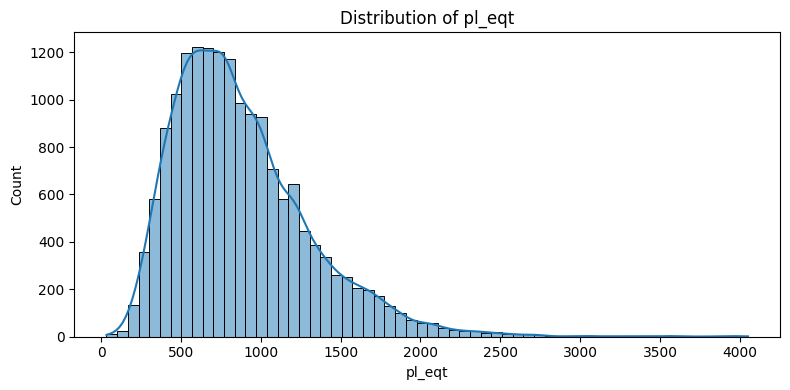

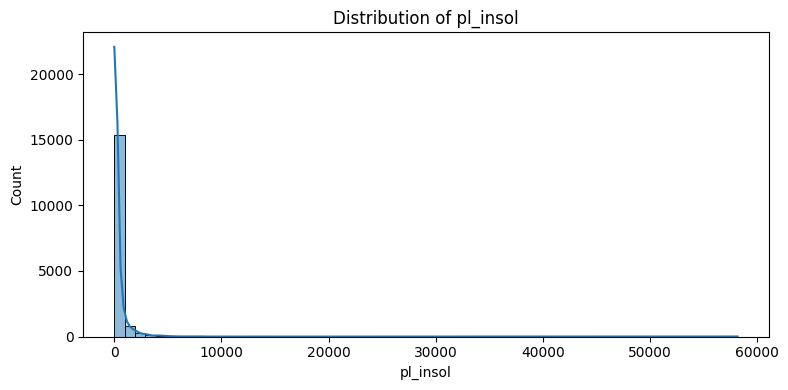

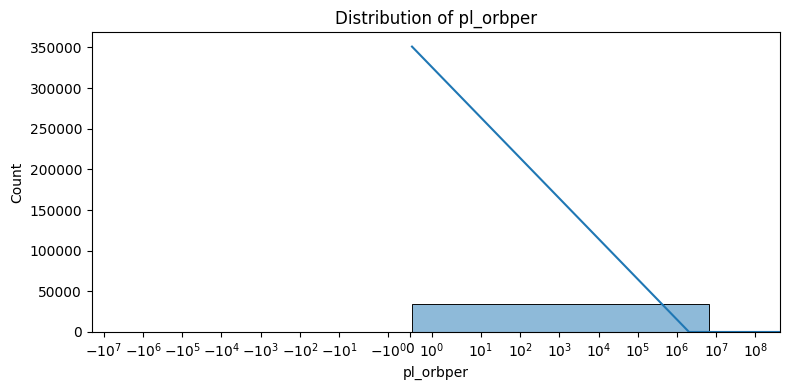

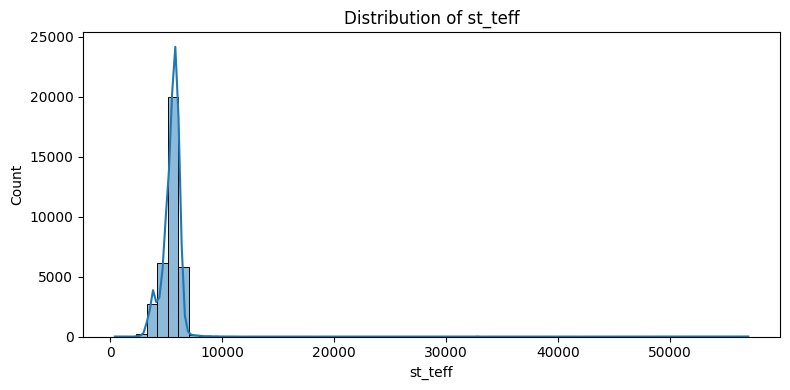

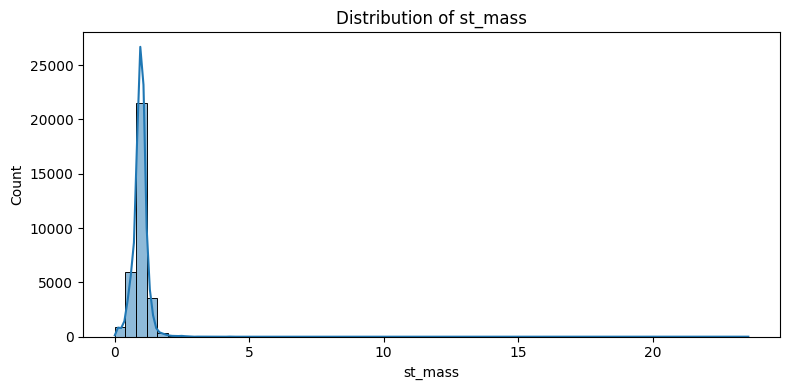

In [8]:
# ----------------------------
# 4) Distribution plots (hist + KDE) for key numeric features
# ----------------------------
key_features = ["pl_rade","pl_bmasse","pl_eqt","pl_insol","pl_orbper","st_teff","st_mass"]
for f in key_features:
    if f in df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(df[f].dropna(), kde=True, bins=60)
        plt.title(f"Distribution of {f}")
        plt.xscale("symlog" if (df[f].max()/max(df[f].min(skipna=True),1e-9) > 1e6 if df[f].min(skipna=True)>0 else False) else "linear")
        plt.tight_layout()
        plt.show()


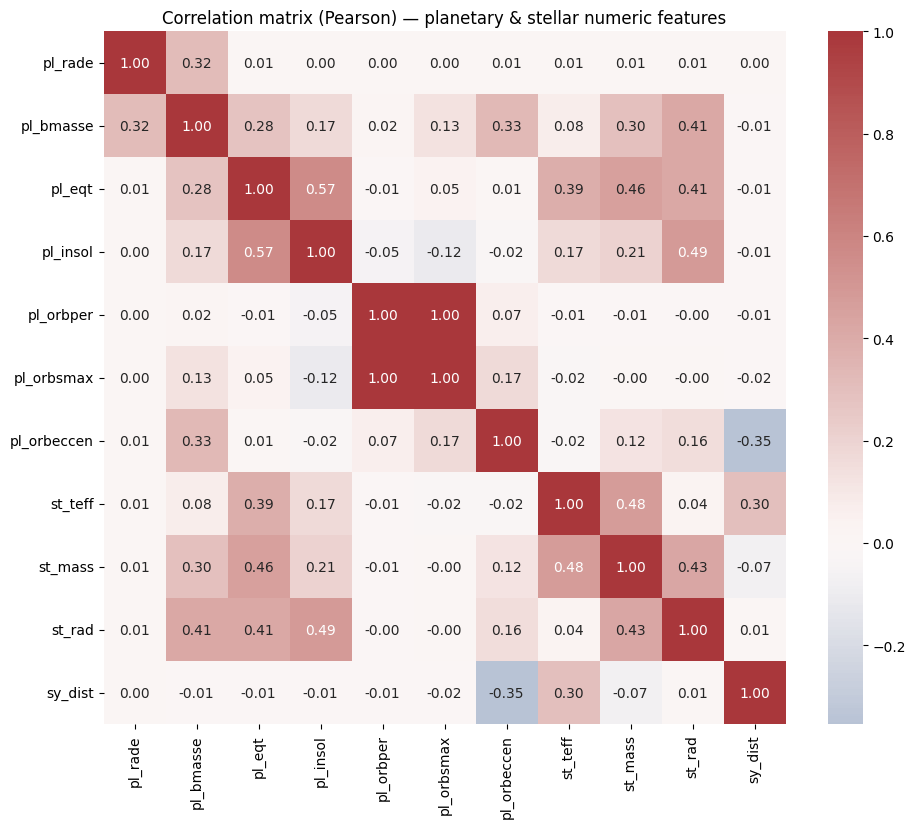

In [9]:
# ----------------------------
# 5) Correlation matrix for numeric columns (Pearson)
# ----------------------------
num_for_corr = [c for c in ["pl_rade","pl_bmasse","pl_eqt","pl_insol","pl_orbper","pl_orbsmax","pl_orbeccen","st_teff","st_mass","st_rad","sy_dist"] if c in df.columns]
corr = df[num_for_corr].corr(method="pearson")
plt.figure(figsize=(11,9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (Pearson) — planetary & stellar numeric features")
plt.show()
